In [1]:
# Since the best way to learn/hack on Dask seems to be by directly editing the installed source code,
# let's have it all reloaded automatically.
#

%load_ext autoreload
%aimport -dask.utils

%autoreload 2

In [2]:
# To set up an environment for this experiment, run:
#    mamba create -n lsd2-2023 -c conda-forge dask pyarrow healpy ipykernel python-graphviz rich ipywidgets python-snappy
# and then create a Jupyter kernel w. something like:
#    conda activate lsd2-2023
#    python -m ipykernel install --user --name lsd2-2023 --display-name "LSD2 (2023)"
#

import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import healpy as hp

import lsdb
import hipscat as hc

print(f"{dask.__version__=}")
print(f"{pd.__version__=}")
print(f"{np.__version__=}")
print(f"{hp.__version__=}")
print(f"{lsdb.__version__=}")
print(f"{hc.__version__=}")


dask.__version__='2022.12.1'
pd.__version__='1.5.2'
np.__version__='1.24.0'
hp.__version__='1.16.1'
lsdb.__version__='0.0.1dev'
hc.__version__='0.0.1dev'


Configure Dask:

In [3]:
# from dask.diagnostics import ProgressBar
#ProgressBar().register()

In [4]:
dask.config.set(temporary_directory='/epyc/ssd/users/mjuric/tmp')
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

# silence incredibly annoying INFO/WARN gc messages
# FIXME: follow https://dask.discourse.group/t/disable-dask-worker-logs-from-printing-on-console-and-write-to-file/408/4
#  to implement a more fine-grained solution
dask.config.set({'logging.distributed': 'error'});

In [5]:
import glob

inprefix = "/epyc/projects3/sam_hipscat/output/gaia_real"
outprefix = "/epyc/projects3/mjuric_hipscat/foo"

## Demo

Launch Dask cluster:

In [6]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=1, memory_limit="24G", dashboard_address="localhost:23456")

port = client._get_scheduler_info()[1]["services"]["dashboard"]
print("Tunnel SSH command:")
print(f"ssh -L {port}:localhost:{port} epyc.astro.washington.edu")

client

Tunnel SSH command:
ssh -L 23456:localhost:23456 epyc.astro.washington.edu


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:23456/status,
Dashboard: http://127.0.0.1:23456/status,Workers: 16
Total threads: 16,Total memory: 357.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39014,Workers: 16
Dashboard: http://127.0.0.1:23456/status,Total threads: 16
Started: Just now,Total memory: 357.63 GiB
Comm: tcp://127.0.0.1:42148,Total threads: 1
Dashboard: http://127.0.0.1:43191/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:45759,


Full self-driving:

In [8]:
%%time
! rm -fr "{outprefix}"

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
ddf = dd.read_parquet(incat)

ldf = lsdb.from_dask(ddf)
ldf.to_hipscat(outprefix);

CPU times: user 6.74 s, sys: 2.56 s, total: 9.3 s
Wall time: 20.8 s


{'opix': {0: [0, 6], 2: [65, 66, 67]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

A bit more driver input:

In [9]:
%%time
! rm -fr "{outprefix}"

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
counts_df = dd.read_parquet(incat, columns=["ra", "dec"])
cat_df    = dd.read_parquet(incat)

ldf = lsdb.from_dask(cat_df, counts_df=counts_df)
ldf.to_hipscat(outprefix);

CPU times: user 5.93 s, sys: 2.5 s, total: 8.43 s
Wall time: 18.4 s


{'opix': {0: [0, 6], 2: [65, 66, 67]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

Now from CSV:

In [ ]:
%%time
! rm -fr "{outprefix}"

gaiacsv = glob.glob("/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_*.csv.gz")

# FIXME: this is very brittle. column datatypes should be loaded from Gaia's CSV header (or elsewhere).
# also see https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
ddf = dd.read_csv(gaiacsv, comment="#", blocksize=None,
                  dtype={  'phot_bp_n_blended_transits':      'float64',
                           'phot_bp_n_contaminated_transits': 'float64',
                           'phot_rp_n_blended_transits':      'float64',
                           'phot_rp_n_contaminated_transits': 'float64',
                            'phot_proc_mode':                 'float64'
                        })
ldf = lsdb.from_dask(ddf)
ldf.to_hipscat(outprefix);

/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Now let's load from hipscat and have some fun:

In [11]:
ldf = lsdb.read_hipscat(outprefix, columns=["ra", "dec", "source_id", "parallax"])

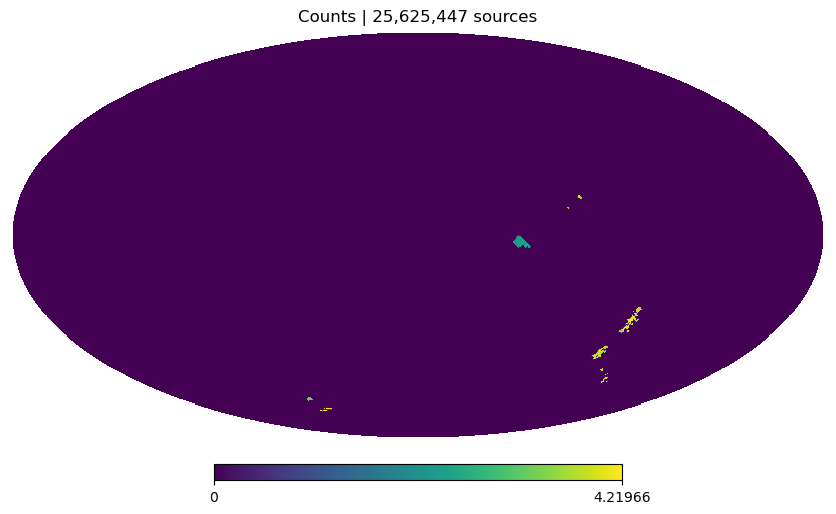

In [12]:
m = lsdb.compute_skymap(ldf)
hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

In [7]:
# some debugging
gaiacsv = glob.glob("/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_*.csv.gz")[-200:]
ddf = dd.read_csv(gaiacsv, comment="#", blocksize=None, dtype={'phot_proc_mode': 'float64'})
m = lsdb.compute_skymap(ddf)
#m.visualize()

## Individual tests
### Pixel-wrangling functions

In [10]:
# test computing the hcidx
import hipscat as hc

try:
    df_orig
except NameError:
    df_orig = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet')
dff = df_orig.copy().iloc[:5]
dff["_ID"] = hc.compute_hcidx(dff["ra"].values, dff["dec"].values)
dff.set_index("_ID", inplace=True)
dff.sort_index(inplace=True)

dff.iloc[:10][["ra", "dec"]]

,ra,dec
_ID,,
4683743707272314880,11.264255,-29.980008
4683743729093181440,11.255093,-29.976936
4683743968771440640,11.280663,-29.960359
4737483338421370880,4.655083,-15.329481
4753396986173980672,13.173931,-11.254662


Partitioning function

3145728


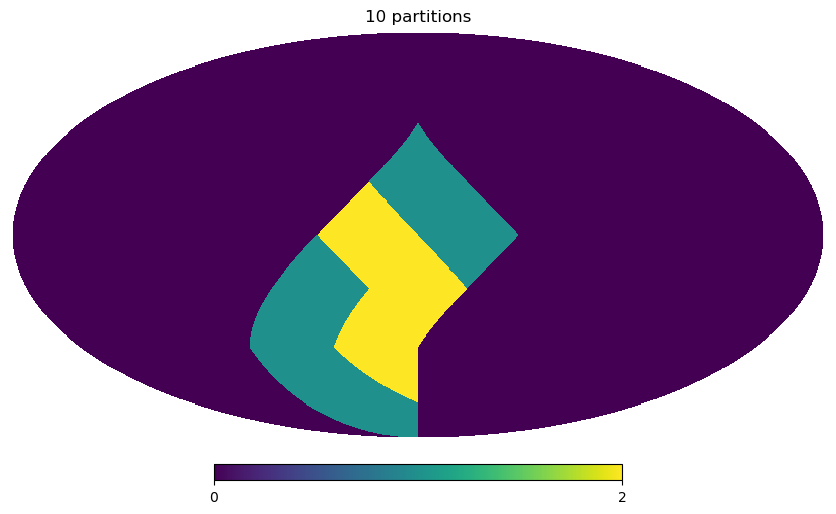

In [13]:
m = np.load("/epyc/projects3/mjuric_hipscat/counts.npy")

opix, orders = hc.compute_partitioning(m)
assert opix[0].dtype == np.uint64

nparts = sum(map(len, opix.values()))
hp.mollview(orders, title=f'{nparts:,.0f} partitions', nest=True)
print(len(orders))

Test the conversion of MOC to orders map

192


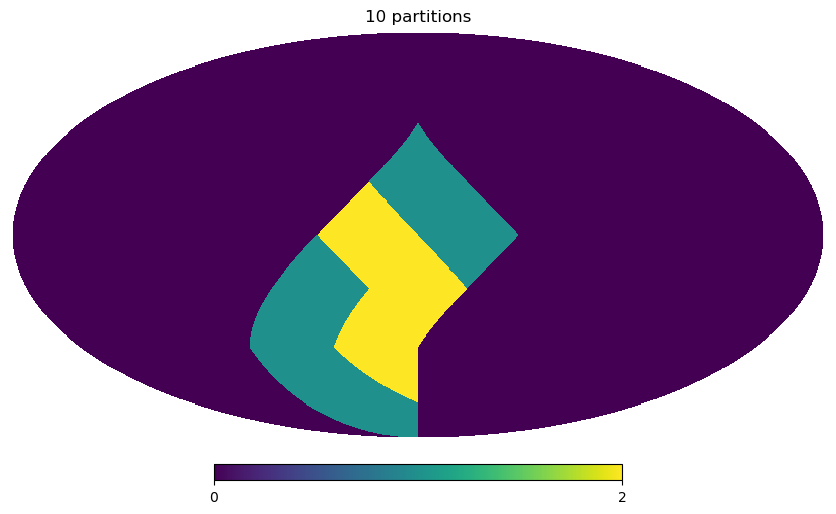

In [14]:
mm = hc.moc2orders(opix)
print(len(mm))
nparts = sum(map(len, opix.values()))
hp.mollview(mm, title=f'{nparts:,.0f} partitions', nest=True)

Test that binning of ra/dec to maps works

In [16]:
df = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet', columns=["ra", "dec"])
m = hc.counts_histogram(df["ra"].values, df["dec"].values, 10)
print(len(m))

12582912


Test building the counts map from a dask dataframe

[########################################] | 100% Completed | 530.05 ms
[########################################] | 100% Completed | 531.11 ms
3145728


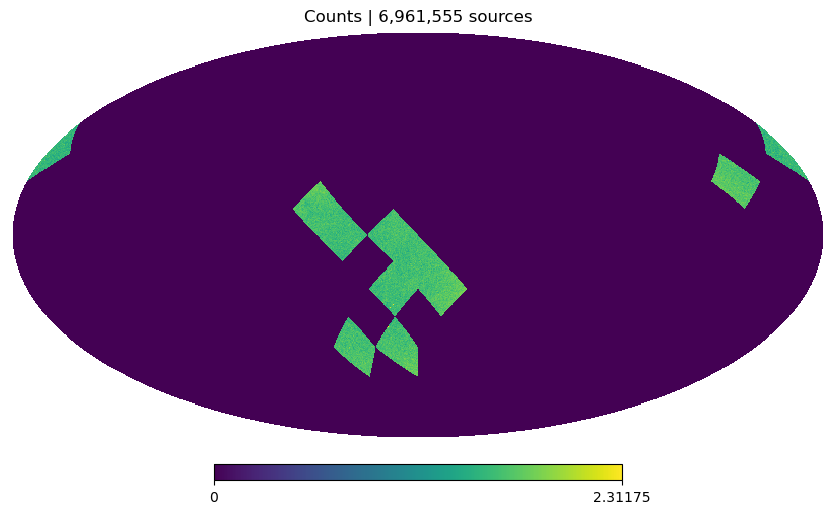

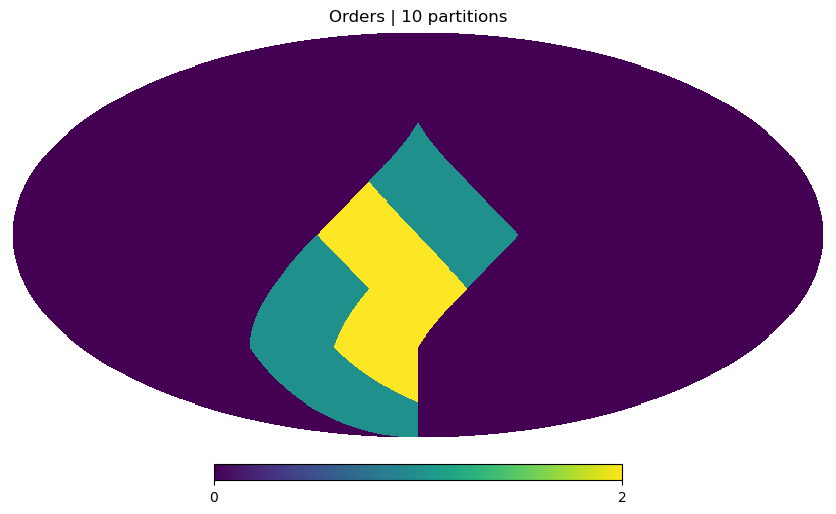

In [19]:
import lsdb

incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])

m = lsdb.compute_skymap(ddf, compute=True)
opix, orders = hc.compute_partitioning(m)

if True:
    print(len(m))
    hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

if True:
    nparts = sum(map(len, opix.values()))
    hp.mollview(orders, title=f'Orders | {nparts:,.0f} partitions', nest=True)

if True:
    np.save("/epyc/projects3/mjuric_hipscat/counts.npy", m)

Test HCMetadata class:

In [20]:
hcmeta = hc.HCMetadata.from_skymap(m)
print(hcmeta)
print(repr(hcmeta.compute_divisions()))

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}
array([                   0,  2305843009213693952,  4683743612465315840,
        4755801206503243776,  4827858800541171712,  4971973988617027584,
        5044031582654955520,  691

Test conversion from parquet to hipscat:

[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]


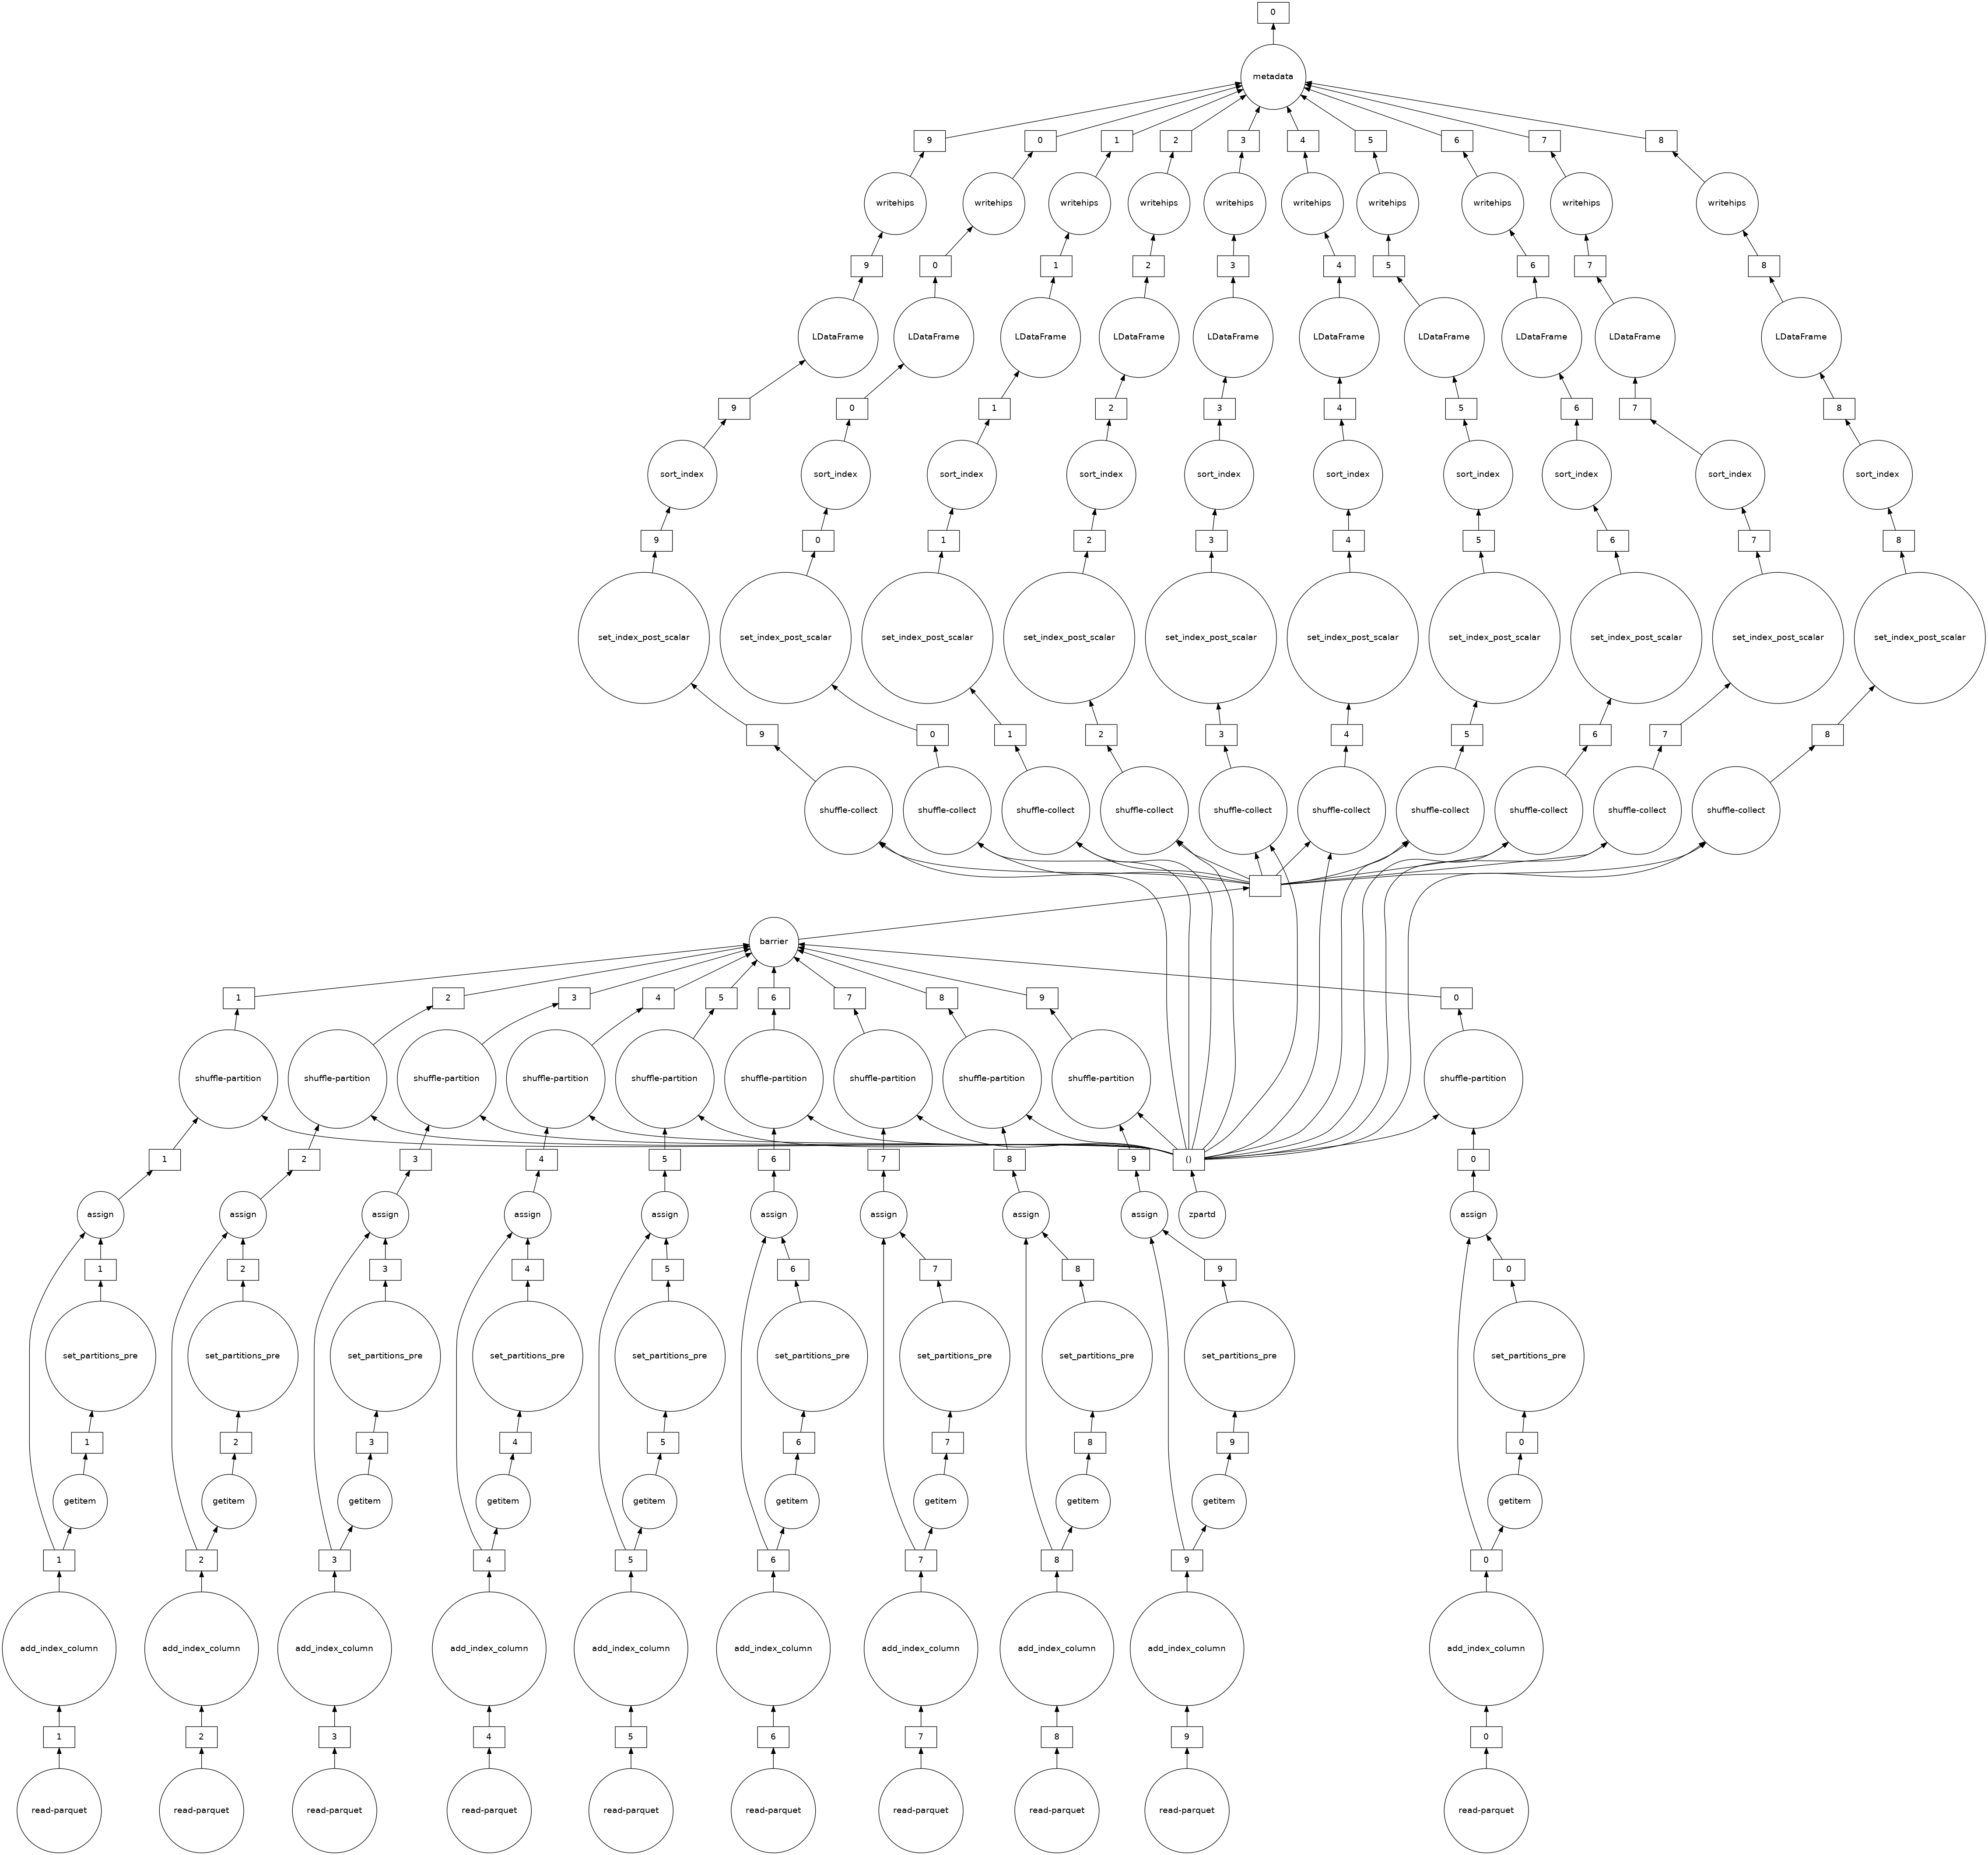

In [28]:
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
graph = ldf.to_hipscat(outprefix, compute=False)
graph.visualize()

Now actually execute:

In [31]:
graph.compute()

[########################################] | 100% Completed | 2.43 ss
[########################################] | 100% Completed | 2.53 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

Now let's test loading from hipscat. First check we can load the metadata:

In [32]:
hc.HCMetadata.from_hipscat("/epyc/projects3/mjuric_hipscat/foo")

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [33]:
tuple(hcmeta.compute_divisions())

(0,
 2305843009213693952,
 4683743612465315840,
 4755801206503243776,
 4827858800541171712,
 4971973988617027584,
 5044031582654955520,
 6917529027641081856,
 9871890383196127232,
 9943947977234055168,
 18446744073709551615)

Test reading hipscat:

In [34]:
df = lsdb.read_hipscat("/epyc/projects3/mjuric_hipscat/foo", columns=['ra', 'dec'])
print(f"ndivisions={len(df.divisions)}: {df.divisions[:5]} ...")
assert df.divisions and df.divisions[0] is not None
print(len(df))
type(df)

ndivisions=11: (0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712) ...
[########################################] | 100% Completed | 385.34 ms
[########################################] | 100% Completed | 484.37 ms
6961555


lsdb.core.LSDBDaskDataFrame

Test that Dask Pandas-like operations work:

In [35]:
df[df["ra"] > 10].compute()

[########################################] | 100% Completed | 571.03 ms
[########################################] | 100% Completed | 612.19 ms


,ra,dec
_ID,,
12484345856,44.996155,0.005615
116614234112,45.004978,0.019880
118561439744,45.004320,0.021048
648845197312,44.995037,0.038152
751496593408,44.963896,0.043595
...,...,...
10016004521694593024,11.242555,-30.073218
10016004568852201472,11.262679,-30.064526
10016004596576550912,11.263623,-30.060752


## Test the usability of LSDBDaskDataFrame objects

In [36]:
type(ldf[["ra"]])

lsdb.core.LSDBDaskDataFrame

Why doesn't this return a LSDBDaskDataFrame?

In [37]:
type(ldf.query("ra > 100"))

dask.dataframe.core.DataFrame

## Demo

In [38]:
# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:10]
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
m = lsdb.compute_skymap(ddf)
opix, orders = hc.compute_partitioning(m)
hcmeta = hc.HCMetadata.from_skymap(m)

# Create and write the full catalog
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat)
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
ldf.to_hipscat(outprefix)

[########################################] | 100% Completed | 600.62 ms
[########################################] | 100% Completed | 674.00 ms
[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]
[########################################] | 100% Completed | 118.72 s
[########################################] | 100% Completed | 118.82 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [31]:
! du -kh /epyc/projects3/mjuric_hipscat/foo

369M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix0
397M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix2
283M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix6
1.1G	/epyc/projects3/mjuric_hipscat/foo/Norder0
328M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix65
395M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix66
322M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix69
339M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix67
333M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix70
374M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix138
355M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix137
2.4G	/epyc/projects3/mjuric_hipscat/foo/Norder2
3.5G	/epyc/projects3/mjuric_hipscat/foo


## The kind of Construction API I've been aiming for...

Ideally, I'd really like this:

In [ ]:
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat)

ldf = from_dask_dataframe(ddf, ra_col="ra", dec_col="dec", threshold=1_000_000)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")

but can't quite figure out yet how to pack all of this into a single task graph...

This is where I am right now:

In [ ]:
# General note: the data source should _always_ be a DaskDataFrame.

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
partitioning = create_partitioning(ddf)

# Create and write the full catalog
ddf = dd.read_parquet(incat)
ldf = from_dask_dataframe(ddf, partitioning)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")